# Optimizing Pyspark

In [1]:
import random
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import col
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
import time
import matplotlib.pyplot as plt

Recently, I encountered a challenge with a PySpark job that was taking over 30 minutes to complete. In the world of data processing, time is money—literally—and such a long runtime was simply unacceptable for our needs.

How did I know something was wrong? We were running the Spark job on AWS Glue, and based on my experience as an AWS data engineer, I knew that both PySpark and Glue were capable of much better performance, especially considering the volume of data we were processing.

Determined to optimize the job, I set out to drastically reduce the runtime. After a series of targeted optimizations, I managed to cut it down from 30 minutes to 18, then to 6, and finally, to under 4 minutes. So, let’s start by understanding the problem in more detail, shall we?

 ## The Problem
We are working with data from a Delta table that is divided into distinct groups, such as group_1 through group_5. These groups represent different community activities. A single community member can belong to multiple groups—someone might attend a particular school (group_1), play football (group_2), and participate in the local choir (group_3), among others.

The challenge arises when we need to consolidate this data into a unified list for prize distribution. It’s essential that each community member appears only once in the final list, regardless of how many groups they are part of. This is critical to ensure fairness, avoid duplicate entries, and prevent the overrepresentation of any individual in the final data.

While this example simplifies the problem, it captures the essence of the challenge I faced. Let's start by setting up pyspark

In [7]:
# Replace with your cluster's master URL
master_url = "spark://spark-master:7077"  # Or use the actual hostname or IP

spark = SparkSession.builder \
    .appName("MyLocalSparkJob") \
    .master(master_url) \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/14 15:07:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf

def generate_test_data(spark, names,num_groups=3, overlap=True):
    """
    Generate a list of DataFrames with potential overlapping 'UCIDs' in 'col0'.
    
    Parameters:
        spark (SparkSession): The Spark session object.
        num_cohorts (int): Number of cohorts (DataFrames) to generate.
        overlap (bool): If True, allow overlap of UCIDs between cohorts.
        
    Returns:
        List[DataFrame]: A list of PySpark DataFrames with 'UCID' overlap.
    """
    df_list = []
    
    base_names = names
    
    for i in range(num_groups):
        # Generate a subset of names with potential overlap
        if overlap:
            names = base_names[:i+2]  # Increasing overlap with each cohort
        else:
            ucids = [f'Person_{i}_{j}' for j in range(num_groups)]
        
        # Create a DataFrame for the group
        group_df = spark.createDataFrame([(name, f'Group_{i}') for name in names], ["names", "group_id"])
        df_list.append(group_df)
    
    return df_list


def plot_two_data_lists(data_list1, data_list2, x_labels=None, title="Data Plot", xlabel="X-axis", ylabel="Y-axis", label1="Data 1", label2="Data 2"):
    """
    Plots two data lists on the same axis with custom x-axis labels.

    Parameters:
    - data_list1: The first list of numerical values to plot.
    - data_list2: The second list of numerical values to plot.
    - x_labels: A list of labels for the x-axis. If None, the x-axis will be labeled with indices.
    - title: The title of the plot (default is "Data Plot").
    - xlabel: The label for the x-axis (default is "X-axis").
    - ylabel: The label for the y-axis (default is "Y-axis").
    - label1: The label for the first data list (default is "Data 1").
    - label2: The label for the second data list (default is "Data 2").
    """
    plt.figure(figsize=(10, 5))
    
    # Plot the first data list
    plt.plot(data_list1, marker='o', label=label1)
    
    # Plot the second data list
    plt.plot(data_list2, marker='s', label=label2)
    
    if x_labels:
        plt.xticks(ticks=range(len(x_labels)), labels=x_labels)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()  # Add a legend to differentiate between the two data sets
    plt.show()

In [9]:
def use_loops(df):
    distinct_names = set()
    final_groups = []
    for ind, group in enumerate(df):
        names = set(group.select(sf.collect_set("names")).first()[0])
        keep_names = names - distinct_names
        distinct_names.update(names)
    
        if ind ==0:
            final_groups.append(group)
        else:
            if keep_names:
                final_groups.append(
                    group.join(
                        sf.broadcast(
                            spark.createDataFrame(
                                [(names,) for names in keep_names],
                                ["names"],
                            ) 
                        ),
                        on="names"
                    )
                )
    
    return reduce(DataFrame.unionByName, final_groups)

def use_dataframe_properties(df, num_groups):

    group_ref = ["Group_"+str(i) for i in range(num_groups)]

    mapping_dict = {col_id: idx for idx, col_id in enumerate(group_ref)}
    
    df_with_mapping = df.withColumn('actual_number', sf.create_map([sf.lit(x) for x in sum(mapping_dict.items(), ())])[sf.col('group_id')])
    
    
    window_spec = Window.partitionBy("names").orderBy("actual_number")  # Define an appropriate ordering column
    ranked_df = df_with_mapping.withColumn("rank", sf.row_number().over(window_spec))
    
    return ranked_df.filter(sf.col("rank") == 1)

In [10]:
def compare_two_func(num_groups = [1, 10]):
    
    # Generate test data with overlapping names
    use_loops_times = []
    use_dataframe_propertie_times = []
    for num in num_groups:
        person_list = ["Person_"+str(i) for i in range(100)]
        test_data = generate_test_data(spark,person_list,num_groups=num, overlap=True)
        # Step 1: Union all DataFrames in df_list into a single DataFrame
        unioned_df = reduce(DataFrame.unionByName, test_data)

        start_time = time.time()
        use_loops(test_data).count()
        use_loops_times.append(time.time()-start_time)

        start_time = time.time()
        use_dataframe_properties(unioned_df, num).count()
        use_dataframe_propertie_times.append(time.time()-start_time)

    return use_loops_times, use_dataframe_propertie_times

In [11]:
num_groups = [1, 10, 25, 50]
use_loops_times, use_dataframe_propertie_times = compare_two_func(num_groups)

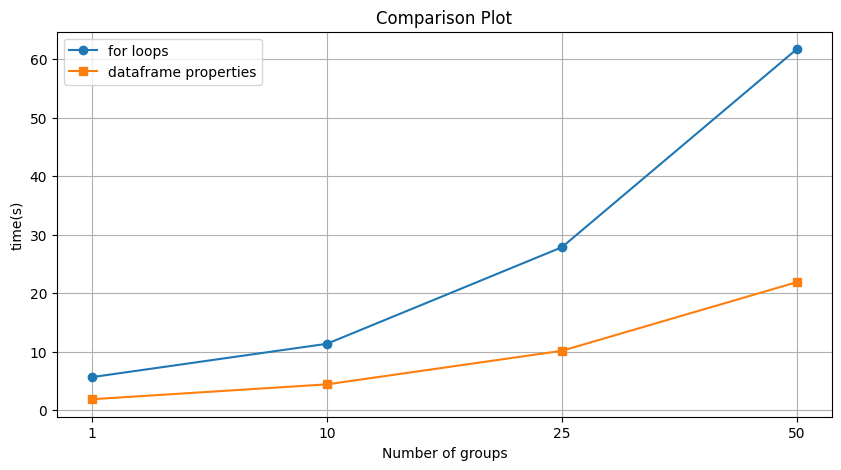

In [12]:
plot_two_data_lists(
    use_loops_times, 
    use_dataframe_propertie_times, 
    title="Comparison Plot", 
    xlabel="Number of groups", 
    x_labels=num_groups,
    ylabel="time(s)", 
    label1="for loops", 
    label2="dataframe properties")

In [30]:
distinct_group_df.drop("actual_number", "rank").show()

+-------+--------+
|  names|group_id|
+-------+--------+
|  Alice| Group_0|
|    Bob| Group_0|
|Charlie| Group_1|
|  David| Group_2|
|    Eve| Group_3|
|  James| Group_4|
+-------+--------+



In [36]:
unioned_df.drop_duplicates(["names"]).show()

+-------+--------+
|  names|group_id|
+-------+--------+
|  Alice| Group_0|
|    Bob| Group_1|
|Charlie| Group_1|
|  David| Group_4|
|    Eve| Group_3|
|  James| Group_4|
+-------+--------+



In [6]:
person_list = ["Person_"+str(i) for i in range(10)]
test_data = generate_test_data(spark,person_list,num_groups=5, overlap=True)
unioned_df = reduce(DataFrame.unionByName, test_data)

In [8]:
unioned_df.isEmpty()

False

In [10]:
unioned_df.printSchema()

root
 |-- names: string (nullable = true)
 |-- group_id: string (nullable = true)



In [13]:
df  = use_dataframe_properties(unioned_df, 5)

In [14]:
df.show()

+--------+--------+-------------+----+
|   names|group_id|actual_number|rank|
+--------+--------+-------------+----+
|Person_0| Group_0|            0|   1|
|Person_1| Group_0|            0|   1|
|Person_2| Group_1|            1|   1|
|Person_3| Group_2|            2|   1|
|Person_4| Group_3|            3|   1|
|Person_5| Group_4|            4|   1|
+--------+--------+-------------+----+



In [18]:
results = df.groupBy("actual_number").agg(sf.count("*").alias("count")).orderBy("actual_number").select('count').collect()

In [20]:
count_list = [row["count"] for row in results]

In [21]:
count_list

[2, 1, 1, 1, 1]

In [23]:
person_list = ["Person_"+str(i) for i in range(100)]
test_data = generate_test_data(spark,person_list,num_groups=100, overlap=True)
unioned_df = reduce(DataFrame.unionByName, test_data)

In [25]:
unioned_df.show(10)

+--------+--------+
|   names|group_id|
+--------+--------+
|Person_0| Group_0|
|Person_1| Group_0|
|Person_0| Group_1|
|Person_1| Group_1|
|Person_2| Group_1|
|Person_0| Group_2|
|Person_1| Group_2|
|Person_2| Group_2|
|Person_3| Group_2|
|Person_0| Group_3|
+--------+--------+
only showing top 10 rows



In [31]:
%%time
unioned_df.select(
    "*"
).show(5)

+--------+--------+
|   names|group_id|
+--------+--------+
|Person_0| Group_0|
|Person_1| Group_0|
|Person_0| Group_1|
|Person_1| Group_1|
|Person_2| Group_1|
+--------+--------+
only showing top 5 rows

CPU times: user 5.22 ms, sys: 2.55 ms, total: 7.77 ms
Wall time: 1.01 s


In [32]:
%%time
unioned_df.select(
    *unioned_df
).show(5)

+--------+--------+
|   names|group_id|
+--------+--------+
|Person_0| Group_0|
|Person_1| Group_0|
|Person_0| Group_1|
|Person_1| Group_1|
|Person_2| Group_1|
+--------+--------+
only showing top 5 rows

CPU times: user 5.24 ms, sys: 2.57 ms, total: 7.8 ms
Wall time: 941 ms


In [28]:
# %%time
# unioned_df.select("names").distinct().rdd.flatMap(lambda x: x).collect()

In [29]:
# %%time
# list(set(unioned_df.select(sf.collect_set("names")).first()[0]))

In [30]:
# %%time
# [row["names"] for row in unioned_df.select("names").distinct().collect()]